In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd

# MINE Ablation Study

Code is taken from MINE implementation directly and some additional changes added

In [2]:
class MineELU(nn.Module):
    def __init__(self, input_size=2, hidden_size=100):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 1)
        nn.init.kaiming_normal_(self.fc1.weight, mode='fan_out')
        nn.init.constant_(self.fc1.bias, 0)
        nn.init.kaiming_normal_(self.fc2.weight, mode='fan_out')
        nn.init.constant_(self.fc2.bias, 0)
        nn.init.kaiming_normal_(self.fc3.weight, mode='fan_out')
        nn.init.constant_(self.fc3.bias, 0)
        
    def forward(self, input_arg):
        output = F.elu(self.fc1(input_arg))
        output = F.elu(self.fc2(output))
        output = self.fc3(output)
        return output
    
class MineReLU(nn.Module):
    def __init__(self, input_size=2, hidden_size=100):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 1)
        
        nn.init.kaiming_normal_(self.fc1.weight, mode='fan_out', nonlinearity='relu')
        nn.init.constant_(self.fc1.bias, 0)
        nn.init.kaiming_normal_(self.fc2.weight, mode='fan_out', nonlinearity='relu')
        nn.init.constant_(self.fc2.bias, 0)
        nn.init.kaiming_normal_(self.fc3.weight, mode='fan_out', nonlinearity='relu')
        nn.init.constant_(self.fc3.bias, 0)
        
    def forward(self, input_arg):
        output = F.elu(self.fc1(input_arg))
        output = F.elu(self.fc2(output))
        output = self.fc3(output)
        return output
    
def mutual_information(joint, marginal, mine_net):
    t = mine_net(joint)
    et = torch.exp(mine_net(marginal))
    mi_lb = torch.mean(t) - torch.log(torch.mean(et))
    return mi_lb, t, et

def learn_mine(batch, mine_net, mine_net_optim,  ma_et, ma_rate=0.01):
    # batch is a tuple of (joint, marginal)
    joint , marginal = batch
    joint = torch.autograd.Variable(torch.FloatTensor(joint))
    marginal = torch.autograd.Variable(torch.FloatTensor(marginal))
    mi_lb, t, et = mutual_information(joint, marginal, mine_net)
    ma_et = (1-ma_rate)*ma_et + ma_rate*torch.mean(et)
    
    # unbiasing use moving average
    loss = -(torch.mean(t) - (1/ma_et.mean()).detach()*torch.mean(et))
    # use biased estimator
#     loss = - mi_lb
    
    mine_net_optim.zero_grad()
    autograd.backward(loss)
    mine_net_optim.step()
    return mi_lb, ma_et

def sample_batch(data, batch_size, sample_mode='joint'):
    if sample_mode == 'joint':
        index = np.random.choice(range(data.shape[0]), size=batch_size, replace=False)
        batch = data[index]
    else:
        joint_index = np.random.choice(range(data.shape[0]), size=batch_size, replace=False)
        marginal_index = np.random.choice(range(data.shape[0]), size=batch_size, replace=False)
        batch = np.concatenate([data[joint_index][:,0].reshape(-1,1),
                                         data[marginal_index][:,1].reshape(-1,1)],
                                       axis=1)
    return batch

def train(data, mine_net,mine_net_optim, batch_size=100, iter_num=int(1e+5), log_freq=int(1e+3)):
    # data is x or y
    result = list()
    ma_et = 1.
    for i in range(iter_num):
        batch = sample_batch(data, batch_size), sample_batch(data, batch_size, sample_mode='marginal')
        mi_lb, ma_et = learn_mine(batch, mine_net, mine_net_optim, ma_et)
        result.append(mi_lb.item())
        if (i+1) % log_freq == 0:
            print(result[-1]) 
    result = np.asarray(result)
    return result

def ma(a, window_size=100):
    return [np.mean(a[i:(i+window_size)]) for i in range(0,len(a)-window_size)]

covariance used in all experiments is selected as 0.8 which is equal to correlation. The relationship between correlation and mutual information is the following for gaussian multivariate random variables [ref](https://lips.cs.princeton.edu/correlation-and-mutual-information/):

\begin{equation*}
    I(X, Y) = -\frac{1}{2}\ln(1 - Corr(X, Y)^2)
\end{equation*}

Therefore, the mutual information $I(X, Y) = 0.51082562376$

In [3]:
cov = [
    [1., .8],
    [.8, 1.]
]

## Sample size effects the performance of the model

**The most the sample size is the better performance results taken from the model.** For the ablation study the following sample sizes are tested with 128 as a batch size and ELU as an activation function using the given MINE model: [128, 256, 512, 1024, 2048]

In [4]:
def plot_sample_size_graphs(results):
    plt.rcParams['figure.dpi']=300
    plt.figure(figsize=(20, 5))
    result_cor_ma = ma(results)
    plt.plot(range(len(result_cor_ma)), result_cor_ma, label='Estimations')
    plt.hlines(0.51082562376, 0, len(result_cor_ma), colors='red', label='Expected mutual information')
    plt.scatter(len(result_cor_ma), result_cor_ma[-1], c='white', zorder=100, label='Final estimation')
    plt.annotate('{:.2f}'.format(result_cor_ma[-1]), (len(result_cor_ma), result_cor_ma[-1]), fontsize=5, zorder=200)
    z = np.polyfit(range(len(result_cor_ma)), result_cor_ma, 2)
    p = np.poly1d(z)
    plt.plot(range(len(result_cor_ma)), p(range(len(result_cor_ma))), label='Trend line of estimations')
    plt.legend()
    plt.ylabel('Mutual information')
    plt.xlabel('# of iterations')

In [5]:
data_X = np.random.multivariate_normal(mean=[0,0], cov=cov, size=128)
mine_net_cor = MineELU()
mine_net_optim_cor = optim.Adam(mine_net_cor.parameters(), lr=1e-3)
result_cor = train(data_X, mine_net_cor, mine_net_optim_cor, batch_size=128)

0.5174359679222107
0.6192241907119751
0.4443202018737793
0.6541152596473694
0.42226406931877136
0.6321029663085938
0.5576659440994263
0.5310984253883362
0.6031786799430847
0.4350043833255768
0.5376700758934021
0.6125888824462891
0.6717621088027954
0.4570312798023224
0.6255371570587158
0.576338529586792
0.4042779207229614
0.7015858888626099
0.4649334251880646
0.22060635685920715
0.4313444495201111
0.6404873132705688
0.5385785698890686
0.5086642503738403
0.5130676627159119
0.4609013795852661
0.630570650100708
0.649039626121521
0.6963651776313782
0.5794291496276855
0.508107602596283
0.5958725810050964
0.46548962593078613
0.5723614692687988
0.697933554649353
0.5613113045692444
0.7144530415534973
0.5625707507133484
0.5349416732788086
0.6087672114372253
0.35338783264160156
0.6004985570907593
0.49364978075027466
0.49920952320098877
0.5345624089241028
0.5740072727203369
0.6490533947944641
0.6393418312072754
0.518110990524292
0.6631256341934204
0.6607029438018799
0.5359517335891724
0.5876714587

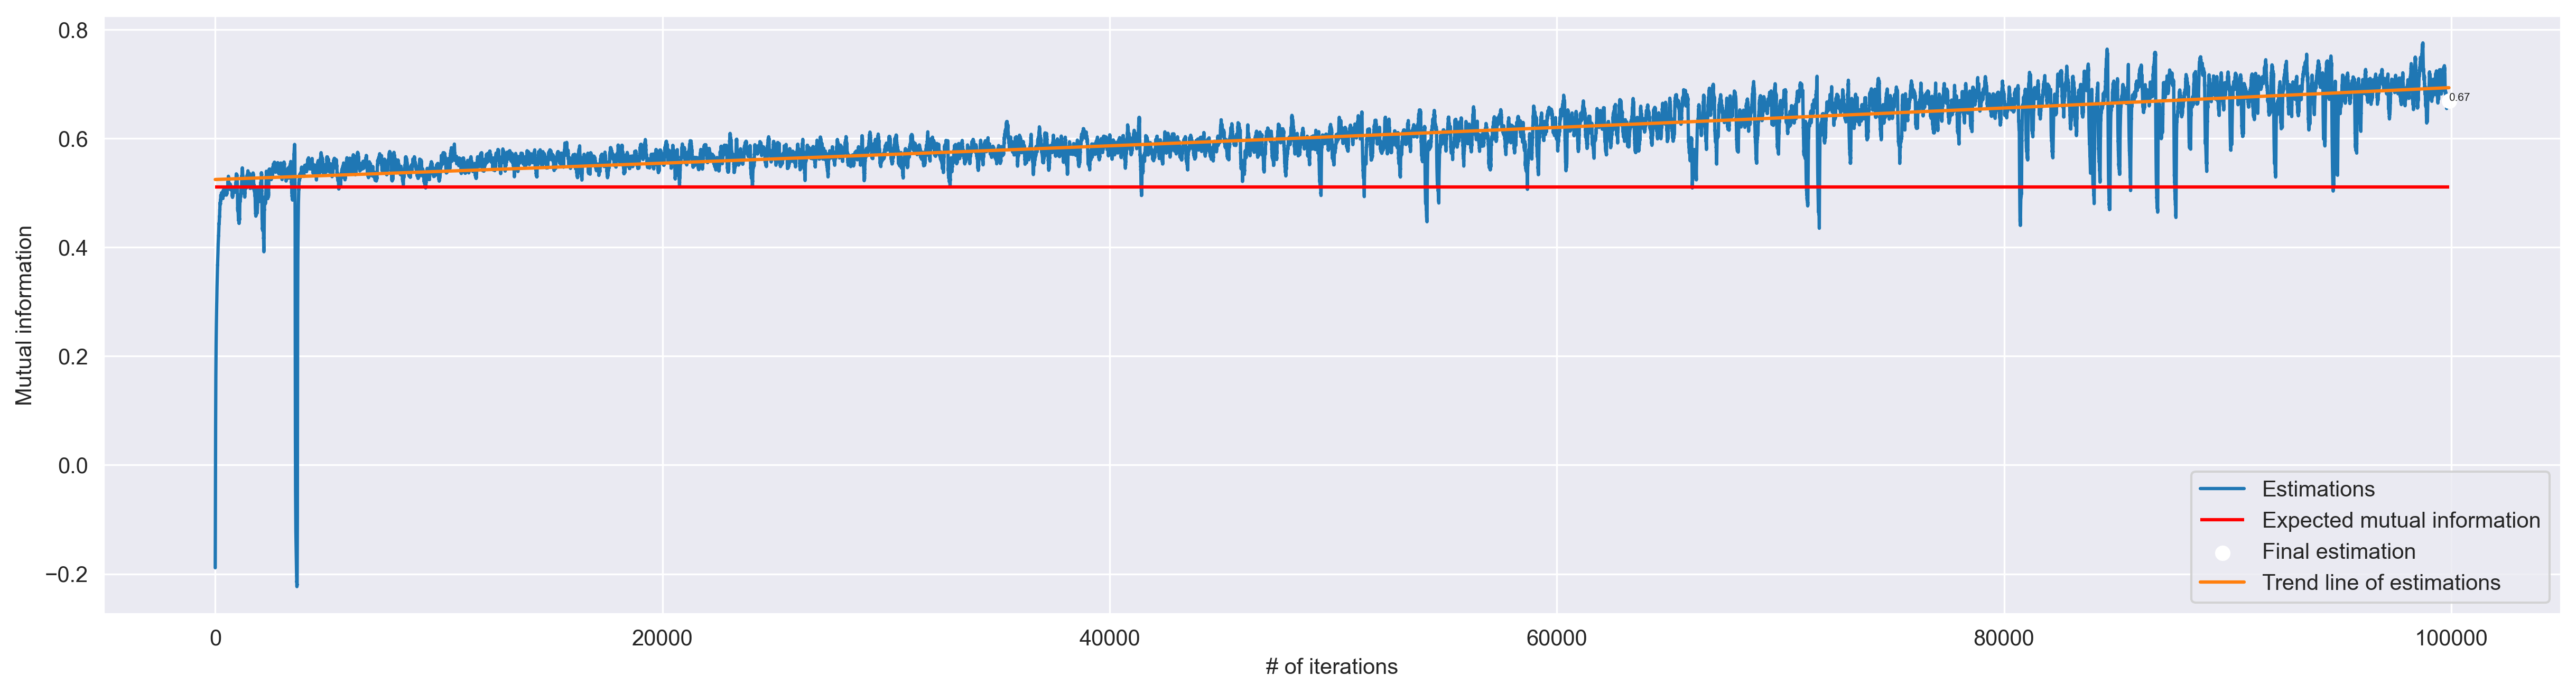

In [56]:
plot_sample_size_graphs(result_cor)

In [5]:
data_X = np.random.multivariate_normal(mean=[0,0], cov=cov, size=256)
mine_net_cor = MineELU()
mine_net_optim_cor = optim.Adam(mine_net_cor.parameters(), lr=1e-3)
result_cor = train(data_X, mine_net_cor, mine_net_optim_cor, batch_size=128)

0.6543808579444885
0.5848432779312134
0.5939186811447144
0.4616762101650238
0.31520792841911316
0.3947674632072449
0.5019654631614685
0.6275794506072998
0.5409051775932312
0.2915663421154022
0.5749340653419495
0.4871278405189514
0.5488435626029968
0.5565106272697449
0.53409343957901
0.6303093433380127
0.6515488028526306
0.4286498725414276
0.5088908672332764
0.3380499482154846
0.4788394868373871
0.5086785554885864
0.3877299129962921
0.5032774209976196
0.43172332644462585
0.5858249664306641
0.4664468765258789
0.5140810012817383
0.5848409533500671
0.3128015100955963
0.4490070343017578
0.4325483739376068
0.5558523535728455
0.6032294631004333
0.5432989597320557
0.5316720008850098
0.550599992275238
0.6514520049095154
0.3658178448677063
0.4356834292411804
0.6383734941482544
0.5762249231338501
0.6071246266365051
0.4330902695655823
0.6951391100883484
0.4423941373825073
0.26544061303138733
0.5264322757720947
0.5743486881256104
0.251010924577713
0.576056718826294
0.46952903270721436
0.58954960107

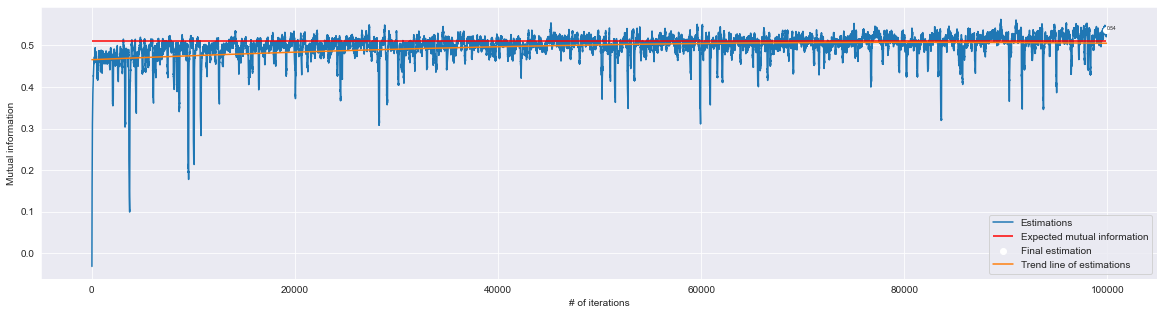

In [6]:
plot_sample_size_graphs(result_cor)

In [7]:
data_X = np.random.multivariate_normal(mean=[0,0], cov=cov, size=512)
mine_net_cor = MineELU()
mine_net_optim_cor = optim.Adam(mine_net_cor.parameters(), lr=1e-3)
result_cor = train(data_X, mine_net_cor, mine_net_optim_cor, batch_size=128)

0.5354605317115784
0.7320902347564697
0.4841426610946655
0.5268951058387756
0.47892308235168457
0.5088556408882141
0.21324419975280762
0.2572801113128662
0.3957574963569641
0.45410609245300293
0.4469989538192749
0.5660249590873718
0.4506891965866089
0.6124356985092163
0.4237784147262573
0.6692225337028503
0.6200506091117859
0.7300313711166382
0.45607447624206543
0.3534306287765503
0.5572575330734253
0.5751461982727051
0.5285046696662903
0.49707233905792236
0.49569934606552124
0.5575628280639648
0.6063898801803589
0.8189298510551453
0.4040168523788452
0.5716594457626343
0.5101646780967712
0.6256042718887329
0.6304101347923279
0.5243825316429138
0.4937219023704529
0.6330392956733704
0.2869076728820801
0.489163875579834
0.5671273469924927
0.5851937532424927
0.47553861141204834
0.25035059452056885
0.7710084319114685
0.6277028322219849
0.6950876712799072
0.5022352933883667
0.5361602306365967
0.6435959339141846
0.5758759379386902
0.498992919921875
0.3426203727722168
0.5876432061195374
0.4062

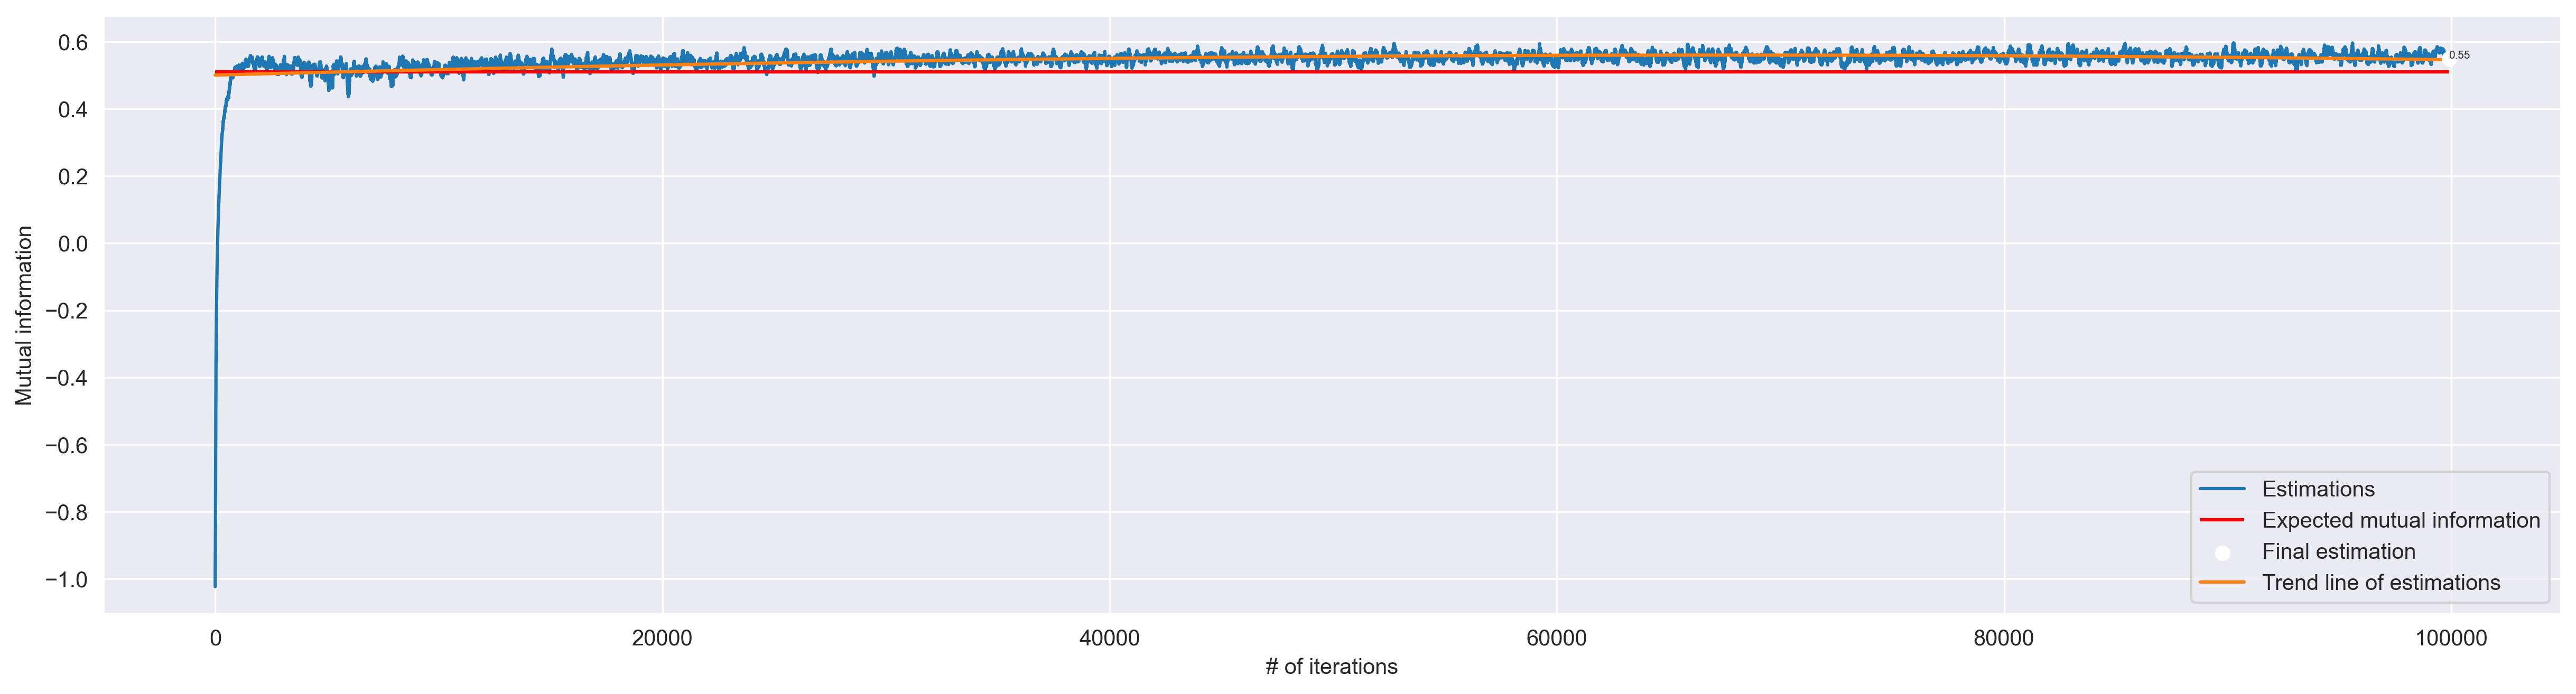

In [8]:
plot_sample_size_graphs(result_cor)

In [9]:
data_X = np.random.multivariate_normal(mean=[0,0], cov=cov, size=1024)
mine_net_cor = MineELU()
mine_net_optim_cor = optim.Adam(mine_net_cor.parameters(), lr=1e-3)
result_cor = train(data_X, mine_net_cor, mine_net_optim_cor, batch_size=128)

0.540107250213623
0.45261144638061523
0.3153042793273926
0.5386080741882324
0.26877641677856445
0.30676794052124023
0.3105301856994629
0.6662440299987793
0.32999706268310547
0.35135746002197266
0.6408534049987793
0.6929059028625488
0.6422457695007324
0.5175175666809082
0.579254150390625
0.6052346229553223
0.5790772438049316
0.6023311614990234
0.5992946624755859
0.6101727485656738
0.5482339859008789
0.5133624076843262
0.6181302070617676
0.2393178939819336
0.5774693489074707
0.5247259140014648
0.711245059967041
0.48419713973999023
0.5652599334716797
0.5525302886962891
0.44042444229125977
0.5598535537719727
0.48815011978149414
0.5509185791015625
0.2678966522216797
0.6367712020874023
0.48037099838256836
0.6820311546325684
0.523801326751709
0.6335334777832031
0.391573429107666
0.5963692665100098
0.4609408378601074
0.42717933654785156
0.37921857833862305
0.49483776092529297
0.48656797409057617
0.5596046447753906
0.5172061920166016
0.32200050354003906
0.5365352630615234
0.6175174713134766
0.2

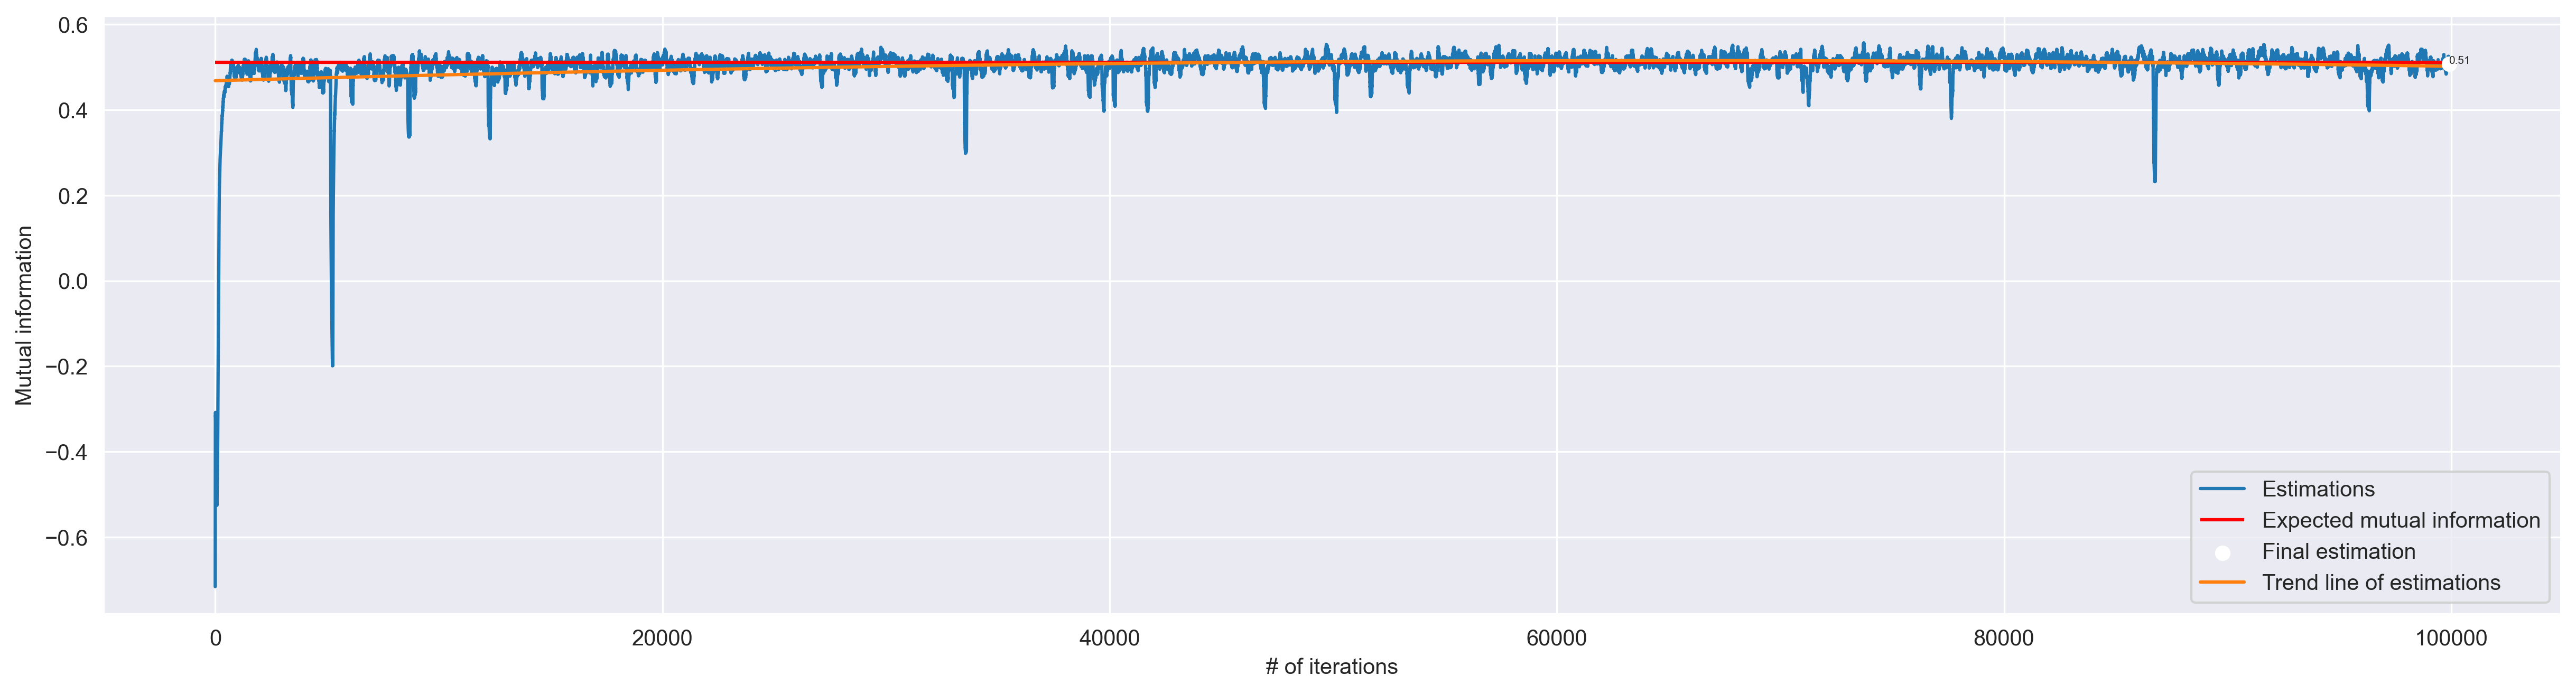

In [10]:
plot_sample_size_graphs(result_cor)

In [11]:
data_X = np.random.multivariate_normal(mean=[0,0], cov=cov, size=2048)
mine_net_cor = MineELU()
mine_net_optim_cor = optim.Adam(mine_net_cor.parameters(), lr=1e-3)
result_cor = train(data_X, mine_net_cor, mine_net_optim_cor, batch_size=128)

0.22794583439826965
0.5026991963386536
0.5490812659263611
0.436896413564682
0.7223831415176392
0.6427789330482483
0.38969743251800537
0.4064432382583618
0.5301339626312256
0.5593477487564087
0.5815721750259399
0.7264994382858276
0.6029022932052612
0.6083401441574097
0.4649311602115631
0.48291218280792236
0.3307393193244934
0.32410910725593567
0.5425972938537598
0.6635113954544067
0.6935266852378845
0.4404202997684479
0.633398175239563
0.629797637462616
0.7316006422042847
0.4795222580432892
0.2376626878976822
0.49936643242836
0.7037528157234192
0.46386638283729553
0.4107244908809662
0.5148850679397583
0.4261818528175354
0.6689622402191162
0.4200102984905243
0.5062235593795776
0.5174914002418518
0.44264474511146545
0.661663293838501
0.5826504230499268
0.4342935383319855
0.5555993318557739
0.5434114933013916
0.42872491478919983
0.5909204483032227
0.5148525238037109
0.5424951910972595
0.6209530830383301
0.5817635655403137
0.4799386262893677
0.6767025589942932
0.6104655861854553
0.730401754

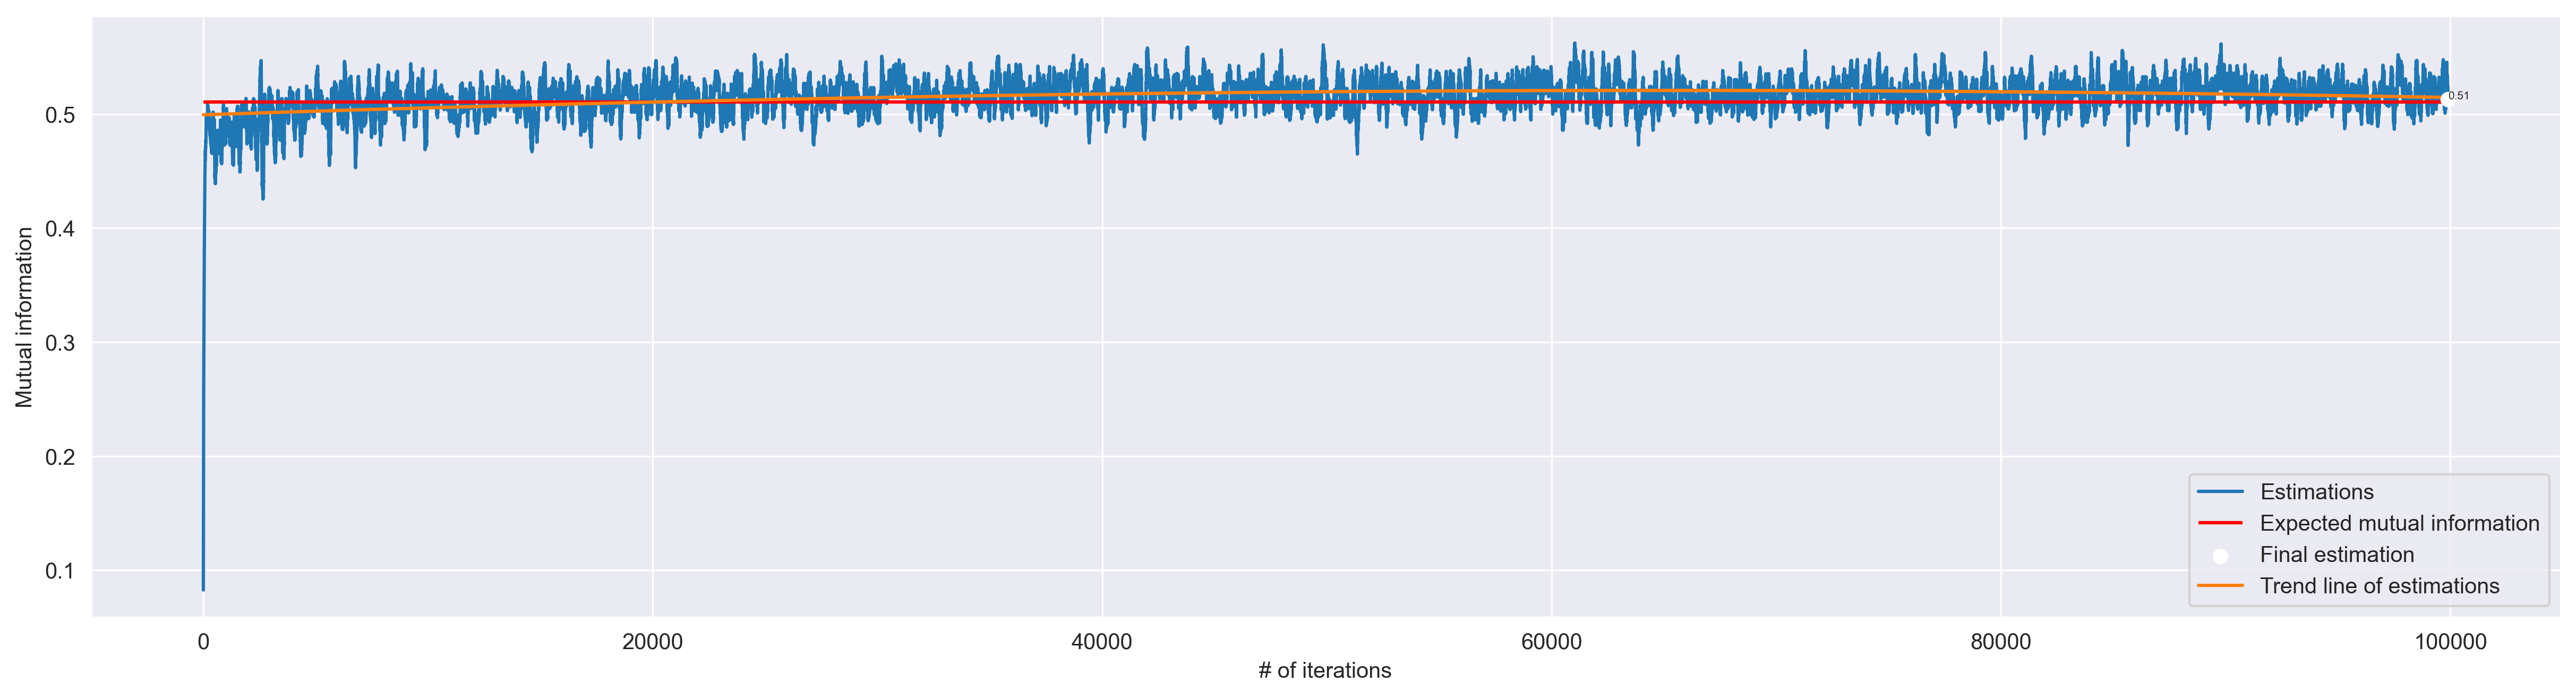

In [12]:
plot_sample_size_graphs(result_cor)

In [13]:
data_X = np.random.multivariate_normal(mean=[0,0], cov=cov, size=2048)
mine_net_cor = MineReLU()
mine_net_optim_cor = optim.Adam(mine_net_cor.parameters(), lr=1e-3)
result_cor = train(data_X, mine_net_cor, mine_net_optim_cor, batch_size=128)

0.4442530870437622
0.575101375579834
0.41317319869995117
0.5576357841491699
0.7007262110710144
0.2800344228744507
0.2770286798477173
0.4913066625595093
0.7043129205703735
0.454118013381958
0.36849796772003174
0.4787082076072693
0.5573798418045044
0.4191265106201172
0.47957974672317505
0.41397666931152344
0.4359222650527954
0.5245002508163452
0.4652754068374634
0.3722645044326782
0.6060429811477661
0.45228779315948486
0.5345959663391113
0.44417381286621094
0.42526400089263916
0.5054027438163757
0.1727125644683838
0.6204659938812256
0.4845319986343384
0.47729575634002686
0.6569808721542358
0.5987164974212646
0.5606405735015869
0.4201178550720215
0.46125757694244385
0.5658977031707764
0.4013688564300537
0.2976052761077881
0.5319315195083618
0.6465387344360352
0.5710614919662476
0.41656768321990967
0.40591704845428467
0.47337114810943604
0.39880168437957764
0.26540184020996094
0.4178422689437866
0.5135037899017334
0.3567981719970703
0.48699116706848145
0.48601484298706055
0.586920261383056

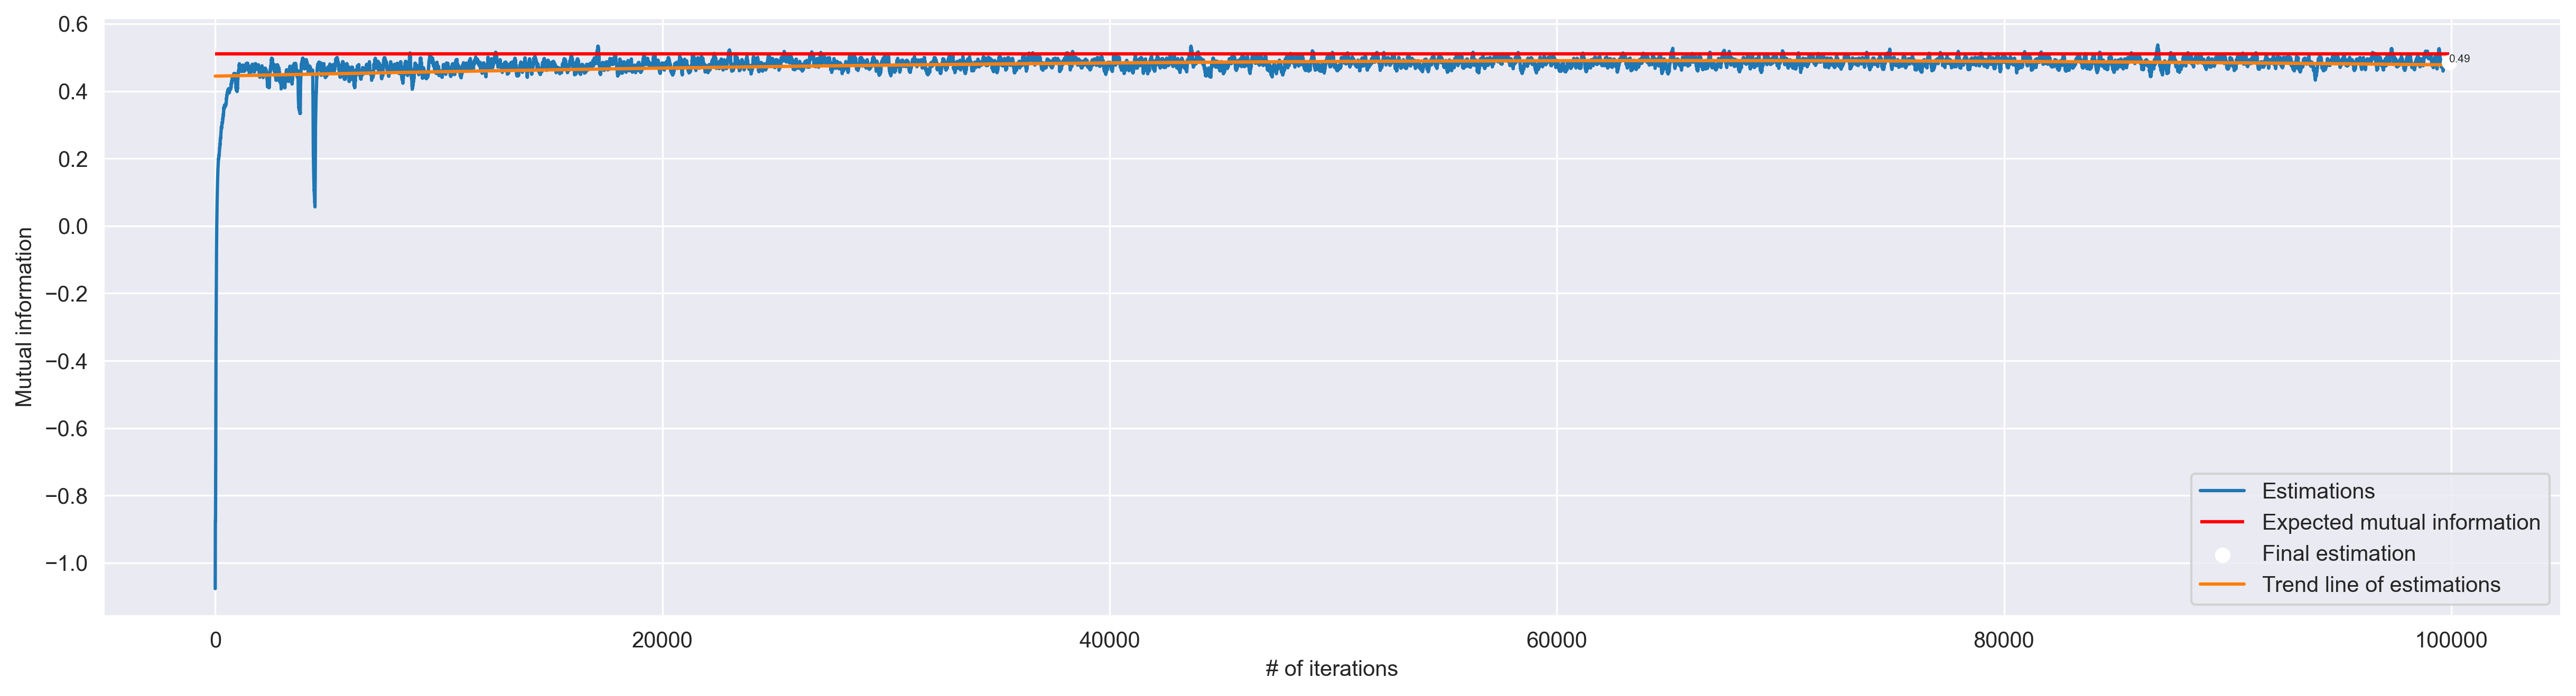

In [14]:
plot_sample_size_graphs(result_cor)

In [15]:
data_X = np.random.multivariate_normal(mean=[0,0], cov=cov, size=2048)
mine_net_cor = MineELU()
mine_net_optim_cor = optim.Adam(mine_net_cor.parameters(), lr=1e-3)
result_cor = train(data_X * 2, mine_net_cor, mine_net_optim_cor, batch_size=128)

0.6895363330841064
0.4456479549407959
0.6090314388275146
0.42744994163513184
0.4467623233795166
0.5130610466003418
0.19868016242980957
0.497295618057251
0.4202282428741455
0.488436222076416
0.6093251705169678
0.38690972328186035
0.4688425064086914
0.5697519779205322
0.535642147064209
0.43514323234558105
0.6509675979614258
0.5847043991088867
0.45568180084228516
0.34037113189697266
0.5221219062805176
0.5083060264587402
0.3170304298400879
0.4950404167175293
0.36405014991760254
0.4691019058227539
0.6952364444732666
0.3549807071685791
0.707188606262207
0.3923318386077881
0.547421932220459
0.65895676612854
0.20215487480163574
0.5137436389923096
0.518481969833374
0.49916648864746094
0.589332103729248
0.4537630081176758
0.6101589202880859
0.5546410083770752
0.6367630958557129
0.22365832328796387
0.4053001403808594
0.6773836612701416
0.7039484977722168
0.700690746307373
0.560579776763916
0.6641507148742676
0.5287673473358154
0.48477697372436523
0.510035514831543
0.43245863914489746
0.3466880321

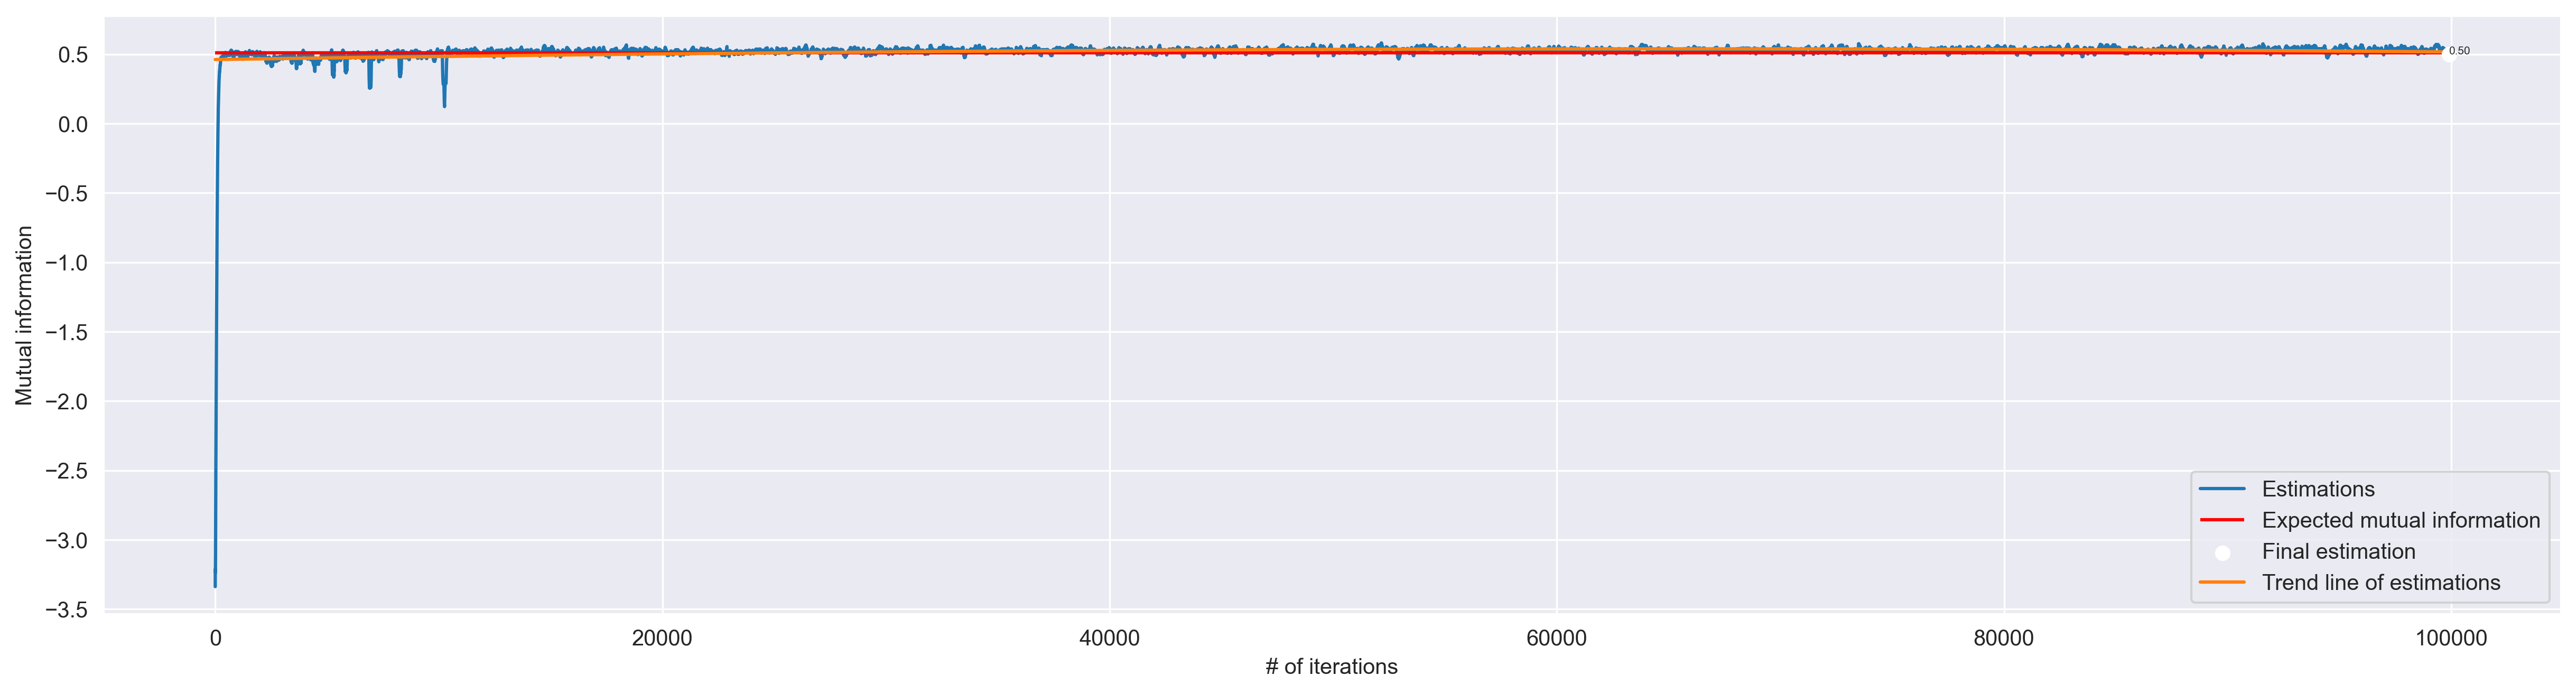

In [16]:
plot_sample_size_graphs(result_cor)